In [1]:
import os
import sys
import torch
import pytorch3d

In [2]:
# Data structures and functions for rendering
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras,
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer
)

from pytorch3d.renderer.mesh.shader import (
    ShaderBase,
)

In [3]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.linalg

In [4]:
# taken from https://github.com/facebookresearch/pytorch3d/blob/main/pytorch3d/renderer/mesh/shader.py

class HardDepthShader(ShaderBase):
    """
    Renders the Z distances of the closest face for each pixel. If no face is
    found it returns the zfar value of the camera.
    Output from this shader is [N, H, W, 1] since it's only depth.
    To use the default values, simply initialize the shader with the desired
    device e.g.
    .. code-block::
        shader = HardDepthShader(device=torch.device("cuda:0"))
    """

    def forward(self, fragments, meshes, **kwargs) -> torch.Tensor:
        cameras = self.cameras

        zfar = kwargs.get("zfar", getattr(cameras, "zfar", 100.0))
        mask = fragments.pix_to_face[..., 0:1] < 0

        zbuf = fragments.zbuf[..., 0:1].clone()
        zbuf[mask] = zfar
        return zbuf

In [5]:
device = torch.device("cpu")

In [6]:
metadata_camera_parameters_csv_file = os.path.join("..", "metadata_camera_parameters.csv")

scene_name  = "ai_037_002"
camera_name = "cam_00"
frame_id    = 0

camera_dir = os.path.join(scene_name, "_detail", camera_name)
img_dir    = os.path.join(scene_name, "images")

# we need access to the Hypersim meshes in order to execute parts of this notebook
mesh_dir = "/Volumes/lacie/hypersim/evermotion_dataset/scenes/" + scene_name + "/_detail/mesh"

In [7]:
mesh_vertices_hdf5_file = os.path.join(mesh_dir, "mesh_vertices.hdf5")
mesh_faces_vi_hdf5_file = os.path.join(mesh_dir, "mesh_faces_vi.hdf5")

with h5py.File(mesh_vertices_hdf5_file, "r") as f: mesh_vertices   = f["dataset"][:]
with h5py.File(mesh_faces_vi_hdf5_file, "r") as f: mesh_faces_vi   = f["dataset"][:]

mesh_positions_world = mesh_vertices

camera_positions_hdf5_file    = os.path.join(camera_dir, "camera_keyframe_positions.hdf5")
camera_orientations_hdf5_file = os.path.join(camera_dir, "camera_keyframe_orientations.hdf5")

with h5py.File(camera_positions_hdf5_file,    "r") as f: camera_positions    = f["dataset"][:]
with h5py.File(camera_orientations_hdf5_file, "r") as f: camera_orientations = f["dataset"][:]

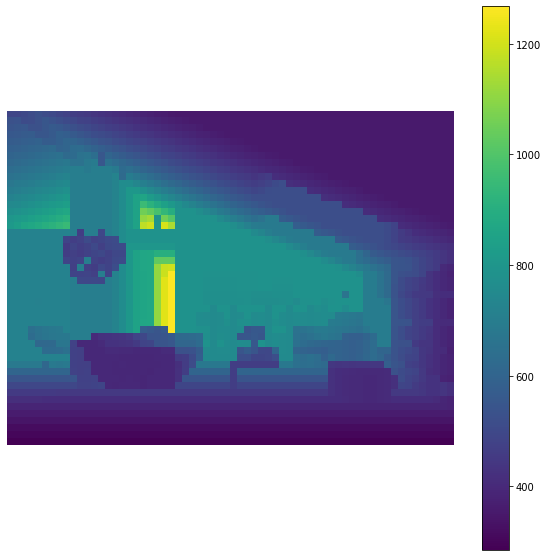

In [9]:
camera_position_world = camera_positions[frame_id]
R_world_from_cam      = camera_orientations[frame_id]

t_world_from_cam = np.matrix(camera_position_world).T
R_cam_from_world = np.matrix(R_world_from_cam).T
t_cam_from_world = -R_cam_from_world*t_world_from_cam

M_cam_from_world = np.matrix(np.block([[R_cam_from_world,       t_cam_from_world],
                                       [np.matrix(np.zeros(3)), 1.0]]))

#
# load per-scene Hypersim camera intrinsics data
#

df_camera_parameters = pd.read_csv(metadata_camera_parameters_csv_file, index_col="scene_name")
df_ = df_camera_parameters.loc[scene_name]

# divide image width and height by k to make rendering go faster
k = 16
width_pixels  = int(df_["settings_output_img_width"] / k)
height_pixels = int(df_["settings_output_img_height"] / k)

if df_["use_camera_physical"]:
    fov_x = df_["camera_physical_fov"]
else:
    fov_x = df_["settings_camera_fov"]

fov_y = 2.0 * np.arctan(height_pixels * np.tan(fov_x/2.0) / width_pixels)

M_cam_from_uv = np.matrix([[ df_["M_cam_from_uv_00"], df_["M_cam_from_uv_01"], df_["M_cam_from_uv_02"] ],
                           [ df_["M_cam_from_uv_10"], df_["M_cam_from_uv_11"], df_["M_cam_from_uv_12"] ],
                           [ df_["M_cam_from_uv_20"], df_["M_cam_from_uv_21"], df_["M_cam_from_uv_22"] ]])

M_cam_from_uv_canonical = np.matrix([[np.tan(fov_x/2.0), 0.0,               0.0],
                                     [0.0,               np.tan(fov_y/2.0), 0.0],
                                     [0.0,               0.0,               -1.0]])

# PyTorch3D seems to have problems with the non-standard perspective projection matrices
# found in Hypersim, so we construct a matrix to transform a camera-space point from its
# original position to a warped position, such that the warped position can be projected
# with a standard perspective projection matrix. This matrix completely accounts for the
# non-standard Hypersim camera parameters.
M_warp_cam_pts_ = M_cam_from_uv_canonical*M_cam_from_uv.I
M_warp_cam_pts  = scipy.linalg.block_diag(M_warp_cam_pts_, 1)

# construct a matrix to account for the different camera-space conventions in Hypersim and PyTorch3D
#   Hypersim:  +x points to the right, +y points up, +z points away from the viewing direction
#   PyTorch3D: +x points to the left,  +y points up, +z points towards the viewing direction
M_p3dcam_from_cam = np.matrix(np.identity(4))
M_p3dcam_from_cam[0,0] = -1
M_p3dcam_from_cam[2,2] = -1

#
# We transform our vertices into camera-space manually, because this enables us to account
# for Hypersim's non-standard camera parameters purely in camera-space. We can then use the
# default perspective projection matrix available in PyTorch3D.
#

num_points = mesh_positions_world.shape[0]

P_world  = np.matrix( np.c_[ mesh_positions_world, np.ones(num_points) ] ).T
P_p3dcam = M_p3dcam_from_cam*M_warp_cam_pts*M_cam_from_world*P_world

# construct PyTorch3D mesh
verts = torch.tensor(P_p3dcam.T[:,0:3], device=device, dtype=torch.float32)
faces = torch.tensor(mesh_faces_vi, device=device)
mesh  = Meshes(verts=[verts], faces=[faces])

# aspect_ratio refers to the pixel aspect ratio, so we set it to 1.0 even though our images are not square
cameras = FoVPerspectiveCameras(device=device, fov=fov_y, degrees=False, aspect_ratio=1.0, znear=1.0, zfar=400.0)

raster_settings = RasterizationSettings(
    image_size=[height_pixels, width_pixels],
    blur_radius=0.0, 
    faces_per_pixel=1, 
)

renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=HardDepthShader(
        device=device, 
        cameras=cameras
    )
)

# render
images = renderer(mesh)

plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., 0].cpu().numpy())
plt.colorbar()
plt.axis("off");